<h1 align='center' style="color: blue;">Individual Project - Spring 2022</h1>

You need to work on a popular Fashion MNIST dataset for this project. The dataset includes tiny images of fashion pieces. The objective is to create a set of supervised learning models that can predict the type of item based on its image. You can use all different models that you learned about them in this course for yourr work. Keep in mind that this is a project, not a class assignmnet. So, not all steps are predetermined and you have more flexibility, and the final outcome is likely to be more detailed.

In [1]:
#BASE Packages
import numpy as np
import pandas as pd
import itertools
import os

#TENSORFLOW PACKAGES
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import keras_tuner as kt

#KERAS PACKAGES
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters
from tensorflow.keras import regularizers

#SK LEARN PACKAGES
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


#os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'
#physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


In [3]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(class_names[y_train[10]])

T-shirt/top


In [4]:
#Mapping Clothing
cloth_map = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

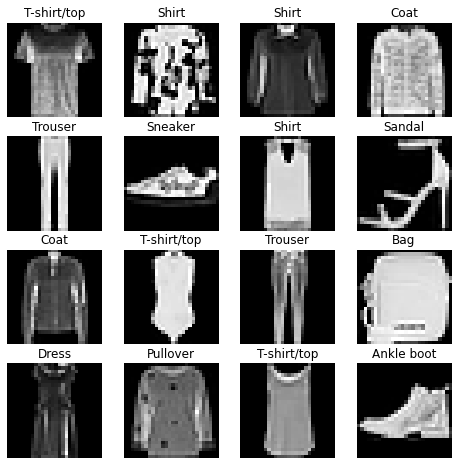

In [5]:
#Visualizating Random images from our training set
fig, axes = plt.subplots(4, 4, figsize = (8,8))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = X_train[index].reshape(28,28)
        cloths = y_train[index]
        axe.imshow(img, cmap='gray')
        axe.set_title(cloth_map[cloths])
        axe.set_axis_off()

#DATA PREPROCESSING

In [6]:
#randomly sort X_test/y_test
#Shuffling to data 5 times to get rid of any existance of patterns
indexes = np.arange(X_test.shape[0])
for _ in range(5): 
    indexes = np.random.permutation(indexes)  # shuffle 5 times
    X_test = X_test[indexes]
    y_test = y_test[indexes]
    
#keep an non pre-processed copy of X_test/y_test for visualization
test_images, test_labels = X_test.copy(), y_test.copy()

# 'split' into Validation & Test sets (7000 records for validation set and 3000 for test set)  
count = 7000
X_val = X_test[:count]
y_val = y_test[:count]
X_test = X_test[count:]
y_test = y_test[count:]





#Scaling the images
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

#Reshaping the Images for NEURAL NETWORK
X_train = X_train.reshape(len(X_train),28,28,1)
X_val = X_val.reshape(len(X_val),28,28,1)
X_test = X_test.reshape(len(X_test),28,28,1)

print('New Shape for Training Data :',X_train.shape)
print('New Shape for Validation Data :',X_val.shape)
print('New Shape for Test Data :',X_test.shape)

New Shape for Training Data : (60000, 28, 28, 1)
New Shape for Validation Data : (7000, 28, 28, 1)
New Shape for Test Data : (3000, 28, 28, 1)


# MODEL 1 - CONVALUTIONAL NEURAL NETWORK (CNN)

TensorFlow and Keras are widely known for their deep learning capability hence I chose my first model as CNN. It is widely used and is famous for image processing and I believe this would be an excellent model to predict garments accurately. 

I have built this model based on the best hyper-parameters that I could find.
I have used Keras-Tuner to tune my neural network. Same is implemented for some of the SKlearn models coming up ahead.

Layers that I have used - 
1) Convolutional Layers - Building blocks of ConvNets. Convolutional Layers has set of Independent Filters whose depth is equal to Input and other dimensions can be set manually. These Filters when convolved over the Input Image produce Feature Maps.

2) Pooling Layers - Used for Dimensionality Reduction or DownSampling the Input. These are used where we have lot of Input Features. It reduces the amount of Parameters and Computational power required drastically, thus reducing Overfitting. These along with Convolutional layers are able to learn more Complex features of the Image

3) Batch Normalization  -  It scales down outliers and forces the network to learn features in a distributed way, not relying too much on a Particular Weight and makes the model better Generalize the Images.

4) Dropout - Added to avoid Overfitting. This randomly drops some percentage of neurons, and thus the weights gets Re-Aligned. 

5) Flatten layer - Added to map the input to a 1D vector. We then add Fully connected Layers after some convolutional/pooling layers. It combines all the Features of the Previous Layers.

6) Output Layer - Contains units equal to the number of classes to be identified(In this case 10) . Here, we are using 'softmax' activation function as we have to deal with Multi-Class Classification.



In [7]:
#Hyper Parameter Tuning for CNN 
import keras_tuner as kt
def cnn_model(hp):
    cnn=keras.Sequential([ 
        keras.layers.Conv2D(                                                           #CONVALUTION LAYER 1
            filters=hp.Int('conv_filter_1',min_value=32,max_value=128,step=32),
            kernel_size = hp.Choice('conv_kernal_1',values=[3,5]),
            activation = 'relu',
            padding='same',
            strides=1,
            input_shape= (28,28,1)
        ),
        
        #keras.layers.BatchNormalization(),
        keras.layers.Dropout(hp.Choice('Drop_rate_1',values=[0.2,0.5])),
        
        keras.layers.Conv2D(                                                          #CONVALUTION LAYER 2
            filters=hp.Int('conv_filter_2',min_value=64,max_value=128,step=32),
            kernel_size = hp.Choice('conv_kernal_2',values=[3,5]),
            activation = 'relu',
            padding='same',
            strides=1
            
        ),
        
        #keras.layers.BatchNormalization(),
        keras.layers.Dropout(hp.Choice('Drop_rate_2',values=[0.2,0.5])),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
       
        keras.layers.Flatten(),
        keras.layers.Dense(                                                          #FULLY CONNECTED LAYER
            units= hp.Int('dense_units_1',min_value=64,max_value=128,step=32),
            activation = 'relu'
       
        ),
        
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(hp.Choice('Drop_rate_2',values=[0.2,0.5])),
            
        keras.layers.Dense(10,activation='softmax')                                 #OUTPUT LAYER
    ])
    

#The compilation is the final step in creating a model. 
    cnn.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    return cnn

In [8]:
#Initializing Random Search and setting evalution metric as validation_accuracy
tuner_search = RandomSearch(cnn_model,
                            objective='val_accuracy',
                            max_trials=5,
                            directory='Neural Net Outputs',
                            project_name="CNN_TRAIL_1")

#Finally here we are running our search to find the appropriate parameters
#Each Epoch consists of 5 trials and hence the model will run for a total of 25 trials
tuner_search.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))
best_model = tuner_search.get_best_models(num_models=1)[0]
best_model.summary()

Trial 5 Complete [00h 05m 20s]
val_accuracy: 0.9231428503990173

Best val_accuracy So Far: 0.9231428503990173
Total elapsed time: 00h 20m 10s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
        

## Data Augmentation

Since the images that we are going to test our model on cannot be a true replica of the images we are training our model on, we need send some modified image information to our model so that it can generalize the image objects better.

Data augmentation is the process of modifying, or “augmenting” a dataset with additional data. This additional data can be anything from images to text, and its use in machine learning algorithms helps improve their performance.

In [9]:
#DATA AUGMENTATION
from keras.preprocessing.image import ImageDataGenerator

imageaugmentation = ImageDataGenerator(
            rotation_range=8,            # randomly rotates image in the range (degrees, 0 to 180)
            zoom_range=0.1,              # Randomly zooms the image 
            shear_range=0.3,             # shifts angle in anti-clockwise direction in degrees  
            width_shift_range=0.07,      # randomly shift images horizontally
            height_shift_range=0.07,     # randomly shift images vertically
            vertical_flip=True)          # randomly flips the image

imageaugmentation.fit(X_train)

#Here are suppling images as a batch to our best model that we got in the last step and implemmenting the augmented
#images
batch_size=128
model1 = best_model.fit(imageaugmentation.flow(X_train,y_train,batch_size=batch_size),
                                          epochs=10,validation_data = (X_val, y_val),
                                  steps_per_epoch=X_train.shape[0] // batch_size,
                                       verbose=1)
                                       

Epoch 1/10


2022-04-05 18:36:03.013001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.8085

2022-04-05 18:36:52.954849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 52s 111ms/step - loss: 0.5288 - accuracy: 0.8085 - val_loss: 0.2613 - val_accuracy: 0.9064
Epoch 2/10
468/468 [==============================] - 51s 110ms/step - loss: 0.4098 - accuracy: 0.8501 - val_loss: 0.2659 - val_accuracy: 0.9064
Epoch 3/10
468/468 [==============================] - 52s 110ms/step - loss: 0.3751 - accuracy: 0.8606 - val_loss: 0.2444 - val_accuracy: 0.9101
Epoch 4/10
468/468 [==============================] - 52s 110ms/step - loss: 0.3539 - accuracy: 0.8708 - val_loss: 0.2390 - val_accuracy: 0.9141
Epoch 5/10
468/468 [==============================] - 52s 110ms/step - loss: 0.3415 - accuracy: 0.8726 - val_loss: 0.2538 - val_accuracy: 0.9093
Epoch 6/10
468/468 [==============================] - 51s 110ms/step - loss: 0.3308 - accuracy: 0.8775 - val_loss: 0.2470 - val_accuracy: 0.9133
Epoch 7/10
468/468 [==============================] - 51s 110ms/step - loss: 0.3247 - accuracy: 0.8799 - val_loss: 0.2447 - val_accuracy: 0.9

In [10]:
#Evaluating with Data Augmentation Model
score = best_model.evaluate(X_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))


# CNN gives good accuracy on unseen data and seems to have resonably less loss

94/94 [==============================] - 1s 10ms/step - loss: 0.2489 - accuracy: 0.9073
Loss: 0.2489
Accuracy: 0.9073


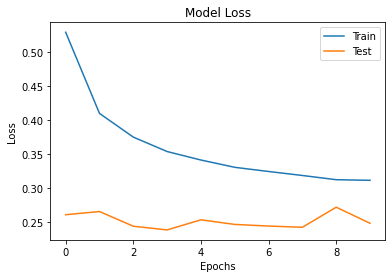

In [11]:
#LOSS PLOT
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

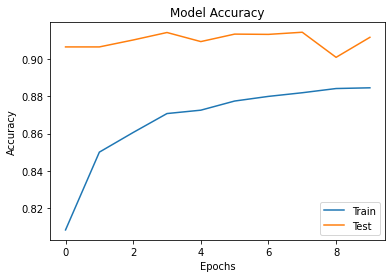

In [12]:
#ACCURACY PLOT
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [13]:
#CONFUSION MATRIX FUNCTION
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

2022-04-05 18:44:42.325167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


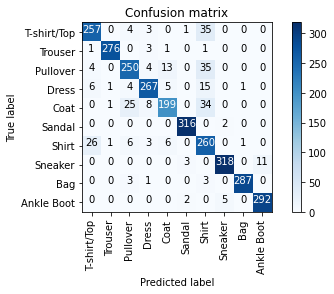

In [14]:
#Plotting the Matrix
Y_pred = best_model.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis=1)

con_mxt = confusion_matrix(y_test,Y_pred_class)
plot_confusion_matrix(con_mxt, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress',
                       'Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [15]:
#Classification Report
print(classification_report(y_test,Y_pred_class))

# report = classification_report(y_test,Y_pred_class,output_dict=True))
# df = pandas.DataFrame(report).transpose()


              precision    recall  f1-score   support

           0       0.87      0.86      0.87       300
           1       0.99      0.98      0.98       282
           2       0.86      0.82      0.84       306
           3       0.92      0.89      0.91       299
           4       0.89      0.75      0.81       267
           5       0.98      0.99      0.99       318
           6       0.68      0.86      0.76       303
           7       0.98      0.96      0.97       332
           8       0.99      0.98      0.98       294
           9       0.96      0.98      0.97       299

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



# ARTIFICIAL NEURAL NETWORK (ANN)

1) Consists of 3 layers Input Hidden and Output Layer
2) I have used Keras Tuner here to find he right number of hidden layers

In [16]:
#Standardizing for ANN
#(X_train_fashion, y_train), (X_test_fashion, y_test) = fashion_mnist.load_data()
train_img = X_train.astype('float32')/255.0
test_img = test_images.astype('float32')/255.0
print('Current Image Shape',train_img[0].shape)
#Reshaping X
train_img = train_img.reshape(len(train_img),28*28)
test_img = test_img.reshape(len(test_img),28*28)
print('New Shape for Training Data :',train_img.shape)
print('New Shape for Test Data :',test_img.shape)


Current Image Shape (28, 28, 1)
New Shape for Training Data : (60000, 784)
New Shape for Test Data : (10000, 784)


# ANN MODEL

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow import keras

def ann_model(hp):
    ann= keras.Sequential()
    for i in range(hp.Int('num_layers',1,20)):
        ann.add(layers.Dense(units = hp.Int('layer_'+str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                            activation='relu',input_shape=(784,)))
    ann.add(layers.Dense(10,activation='softmax'))
    ann.compile(
        optimizer=keras.optimizers.Adam
        (hp.Choice('learning_rate',[1e-2,1e-3])),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return ann
        
    
    
ann_tuner = RandomSearch(ann_model,
                            objective='val_accuracy',
                            max_trials=2,
                            executions_per_trial=2,
                            directory='Neural Net Outputs',
                            project_name="ANN_TRIAL_1")

    
ann_tuner.search(train_img,y_train,epochs=2,validation_split=0.1)

Trial 2 Complete [00h 00m 46s]
val_accuracy: 0.8019166588783264

Best val_accuracy So Far: 0.8019166588783264
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_ann = ann_tuner.get_best_models(num_models=1)[0]
best_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                75360     
                                                                 
 dense_1 (Dense)             (None, 448)               43456     
                                                                 
 dense_2 (Dense)             (None, 416)               186784    
                                                                 
 dense_3 (Dense)             (None, 64)                26688     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 192)               24768     
                                                                 
 dense_6 (Dense)             (None, 320)               6

In [34]:
best_ann.fit(train_img,y_train,epochs=10,validation_split=0.1)

Epoch 1/10
   7/1688 [..............................] - ETA: 14s - loss: 0.5145 - accuracy: 0.7991 

2022-04-05 19:04:48.725585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.8150

2022-04-05 19:04:59.132300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 11s 6ms/step - loss: 0.5012 - accuracy: 0.8150 - val_loss: 0.4466 - val_accuracy: 0.8343
Epoch 2/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.4523 - accuracy: 0.8354 - val_loss: 0.4554 - val_accuracy: 0.8305
Epoch 3/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.4201 - accuracy: 0.8480 - val_loss: 0.4362 - val_accuracy: 0.8472
Epoch 4/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3974 - accuracy: 0.8567 - val_loss: 0.3947 - val_accuracy: 0.8577
Epoch 5/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3776 - accuracy: 0.8621 - val_loss: 0.3653 - val_accuracy: 0.8688
Epoch 6/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3607 - accuracy: 0.8672 - val_loss: 0.3923 - val_accuracy: 0.8610
Epoch 7/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3495 - accuracy: 0.8712 - val_loss: 0.3880 - val_accuracy: 0.8

In [35]:
#Evaluation of Model on Test Data
score = best_ann.evaluate(test_img, y_test)
print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))
y_pred_ann = best_ann.predict(test_img)
y_pred_ann_max = np.argmax(y_pred_ann,axis=1)
print(classification_report(y_test,y_pred_ann_max))

313/313 [==============================] - 1s 4ms/step - loss: 2057.8069 - accuracy: 0.1043
Loss: 2057.8069
Accuracy: 0.1043


2022-04-05 19:06:43.716836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.10      0.10      0.10      1000
           1       0.12      0.18      0.14      1000
           2       0.10      0.14      0.12      1000
           3       0.09      0.07      0.08      1000
           4       0.10      0.19      0.13      1000
           5       0.11      0.05      0.07      1000
           6       0.13      0.03      0.04      1000
           7       0.11      0.04      0.06      1000
           8       0.09      0.11      0.10      1000
           9       0.11      0.14      0.12      1000

    accuracy                           0.10     10000
   macro avg       0.11      0.10      0.10     10000
weighted avg       0.11      0.10      0.10     10000



In [ ]:
con_mxt_ann = confusion_matrix(y_test,y_pred_ann_max)
plot_confusion_matrix(con_mxt_ann, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress',
                       'Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

# Logistic Regression

In [24]:
#PRE PROCESSIG FOR SK LEARN MODELS
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1,28*28).astype('float32')/255.0
X_test = X_test.reshape(-1,28*28).astype('float32')/255.0

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
lr = LogisticRegression(max_iter=1000,solver='newton-cg',penalty='l2')
lr.fit(X_train,y_train)

/Users/saim/miniforge3/envs/tfm1/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/saim/miniforge3/envs/tfm1/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(max_iter=1000, solver='newton-cg')

In [26]:
y_pred_lr = lr.predict(X_test)
from sklearn.metrics import accuracy_score
print('Logistic Regression Accuracy Score: {}'.format(accuracy_score(y_pred_lr,y_test)*100))

Logistic Regression Accuracy Score: 84.42


              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1009
           1       0.96      0.97      0.96       986
           2       0.74      0.73      0.73      1016
           3       0.86      0.83      0.85      1037
           4       0.76      0.74      0.75      1030
           5       0.92      0.94      0.93       977
           6       0.57      0.63      0.60       909
           7       0.94      0.91      0.92      1032
           8       0.94      0.93      0.93      1008
           9       0.95      0.95      0.95       996

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.85      0.84      0.85     10000



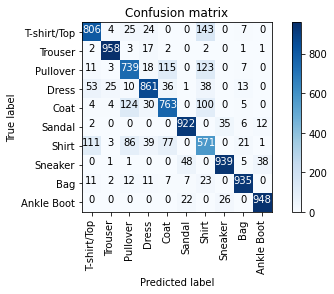

In [27]:
print(classification_report(y_pred_lr,y_test))
con_mxt_lr = confusion_matrix(y_pred_lr,y_test)
plot_confusion_matrix(con_mxt_lr, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress',
                       'Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

## ADABOOST

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

def ADABOOST(hp):
    model = AdaBoostClassifier(
        n_estimators=hp.Int('n_estimators',50,200,step=20))
    
    return model


tuner = kt.tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=2),
    hypermodel= ADABOOST,
    directory='SK LEARN MODELS',
    project_name='ADABOOST_RESULT')
tuner.search(X_train,y_train)

Trial 2 Complete [00h 14m 59s]
score: 0.46645000000000003

Best score So Far: 0.5049833333333333
Total elapsed time: 00h 21m 08s
INFO:tensorflow:Oracle triggered exit


In [37]:
best_ada_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_ada_hp)
model.fit(X_train, y_train)
ada_pred = model.predict(X_test)
RF_ACC = print('ADABOOST Accuracy: {}'.format(accuracy_score(y_test, ada_pred)*100))
print(classification_report(y_test, ada_pred))

ADABOOST Accuracy: 53.98
              precision    recall  f1-score   support

           0       0.39      0.04      0.07      1000
           1       0.87      0.78      0.82      1000
           2       0.30      0.61      0.40      1000
           3       0.56      0.71      0.62      1000
           4       0.48      0.57      0.52      1000
           5       0.61      0.60      0.61      1000
           6       0.24      0.14      0.18      1000
           7       0.52      0.92      0.67      1000
           8       0.92      0.78      0.85      1000
           9       0.82      0.24      0.38      1000

    accuracy                           0.54     10000
   macro avg       0.57      0.54      0.51     10000
weighted avg       0.57      0.54      0.51     10000



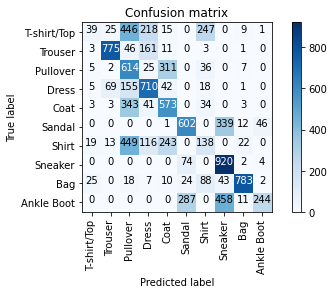

In [38]:
con_mxt_ada = confusion_matrix(y_test, ada_pred)
plot_confusion_matrix(con_mxt_ada, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress',
                       'Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

# RANDOM FOREST


In [28]:
from sklearn.ensemble import RandomForestClassifier

def RF_MOD(hp):
    model = RandomForestClassifier(
        n_estimators=hp.Int('n_estimators',50,200,step=10),
        max_depth=hp.Int('max_depth',3,10))
    
    return model

In [29]:
tuner = kt.tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=5),
    hypermodel= RF_MOD,
    directory='SK LEARN MODELS',
    project_name='Random Forest Results')
tuner.search(X_train,y_train)

Trial 5 Complete [00h 00m 45s]
score: 0.8326

Best score So Far: 0.8436
Total elapsed time: 00h 06m 12s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_rf_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_rf_hp)
model.fit(X_train, y_train)
pred_rf = model.predict(X_test)
RF_ACC = print('Random Forest Score: {}'.format(accuracy_score(y_test, pred_rf)*100))
print(classification_report(y_test,pred_rf))

Random Forest Score: 83.65
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.99      0.94      0.96      1000
           2       0.70      0.71      0.70      1000
           3       0.80      0.90      0.85      1000
           4       0.66      0.79      0.72      1000
           5       0.98      0.93      0.95      1000
           6       0.70      0.46      0.55      1000
           7       0.90      0.92      0.91      1000
           8       0.95      0.96      0.95      1000
           9       0.91      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.83     10000



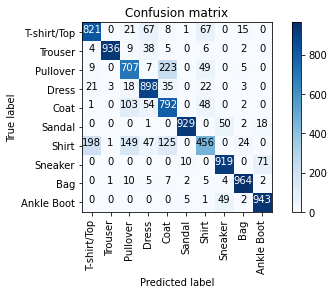

In [31]:
con_mxt_rf = confusion_matrix(y_test,pred_rf)
plot_confusion_matrix(con_mxt_rf, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress',
                       'Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

### I calculated the accuracy, precision , recall and f1 for all the models. The metrices that I am choosing to select the best model are Accuracy and Precision. CNN gives the best output in terms of accuracy (~91%) & precision ( 91%) (approx) 

# Task 2

In [18]:
#STEP 1 ( Converting Images to Binary Image)
import cv2

import glob
img_list = glob.glob('*.jpeg')
for imgs in img_list:
    img = cv2.imread(imgs,2)
    resize = cv2.resize(img,(28,28))
    #ret, bw_img = cv2.threshold(resize,127,255,cv2.THRESH_BINARY)
    cv2.imwrite('resized_'+imgs,resize)

In [19]:
#Step2  Stacking all new images
import imageio
import numpy as np

# # Read in each 2D image
im1 = imageio.imread('resized_img1.jpeg')
im2 = imageio.imread('resized_img2.jpeg')
im3 = imageio.imread('resized_img3.jpeg')
im4 = imageio.imread('resized_img4.jpeg')
im5 = imageio.imread('resized_img5.jpeg')

# Stack images into a single array
img_array = np.stack([im1,im2,im3,im4,im5],axis=0)
print('Volume dimensions:', img_array.shape)

Volume dimensions: (5, 28, 28)


In [20]:
#Scaling and Reshaping
scaled_imgs = img_array.astype('float32')/255.0
scaled_imgs = scaled_imgs.reshape(len(scaled_imgs),28,28,1)

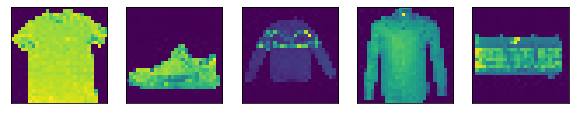

In [21]:
#Visualization
gray_image = scaled_imgs
plt.figure(figsize=(10,10))
for i in range(len(scaled_imgs)):
    plt.subplot(1,len(scaled_imgs),i+1)
    plt.xticks([])        
    plt.yticks([])
    plt.imshow(scaled_imgs[i])
plt.show()
    

In [22]:
predictions = np.argmax(best_model.predict(scaled_imgs),axis=1)
predictions

2022-04-05 18:46:03.166002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0, 7, 2, 6, 8])

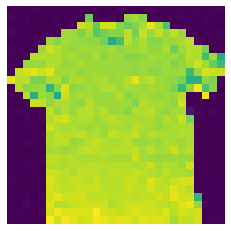

The Predicted class name of the projected image is: T-shirt/top


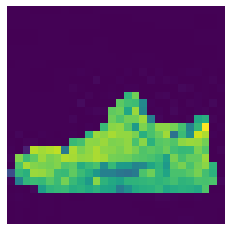

The Predicted class name of the projected image is: Sneaker


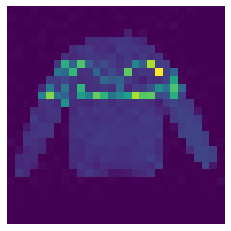

The Predicted class name of the projected image is: Pullover


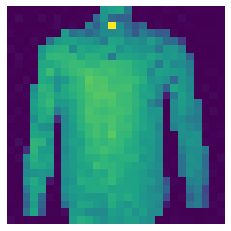

The Predicted class name of the projected image is: Shirt


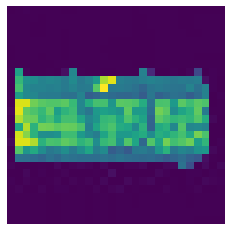

The Predicted class name of the projected image is: Bag


In [23]:

for i in range(len(predictions)):                                 
    new=scaled_imgs[i]
    new_d=new.reshape(28,28,1)
    plt.imshow(new_d)
    plt.axis('off')
    plt.show()
    print("The Predicted class name of the projected image is:", class_names[predictions[i]])

In [39]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(class_names[y_train[10]])

T-shirt/top


## WOHOO! I GUESS CNN DID A PRETTY GOOD JOB